In [20]:
import matplotlib.pyplot as plt
import re
import random
import nltk.data
import spacy 
import string

## Spanish Manual Engine

In [37]:
# Most policies come with the final signatures. This is a piece of text that we want to be able to recognize. To make the
# detection of signatures easier, this dictionary contain the most common terms that can be found in these lines of text.
official_positions = {"ALCALDE" : 0,
"Alcalde" : 0,
"MINISTRA" : 0,
"Ministra" : 0,
"MINISTRO" : 0,
"Ministro" : 0,
"PRESIDENTA" : 0,
"Presidenta" : 0,
"PRESIDENTE" : 0,
"Presidente" : 0,
"REGIDOR" : 0,
"Regidor"  : 0,
"REGIDORA" : 0,
"regidora" : 0,
"SECRETARIA" : 0,
"Secretaria" : 0,
"SECRETARIO" : 0,
"Secretario" : 0,
"SINDICA" : 0,
"Sindica" : 0,
"SINDICO" : 0,
"Sindico" : 0,
"VICEPRESIDENTA" : 0,
"Vicepresidenta" : 0,
"VICEPRESIDENTE" : 0,
"Vicepresidente" : 0
}

end_of_file_tags = {
    "Anótese" : 0,
    "Anotese" : 0,
    "Publíquese" : 0,
    "Publiquese" : 0
}
# This dictionary contains some correspondences among different text headings. This is under development and needs further
# improvement.The idea is to merge in a single name all the headings that point to the same conceptual concept. For example,
# "Definiciones" is a heading that can come alone or together with other terms so it can appear as "Definiciones básicas" or
# "Definiciones generales". With the dictionary we can fetch all headings that contain the word "Definiciones" and change the
# heading to "Definiciones".
merges = {
    "CONCEPTOS" : "DISPOSICIONES GENERALES",
    "Considerando:" : "CONSIDERANDO",
    "DEFINICIONES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES FINALES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES GENERALES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES PRELIMINARES" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES REGULADORAS" : "DISPOSICIONES ESPECIALES",
    "DISPOSICIONES RELATIVAS" : "DISPOSICIONES ESPECIALES",
    "DISPOSICIONES ESPECIALES" : "DISPOSICIONES ESPECIALES",
    "DISPOSICIONES TRANSITORIAS" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES VARIAS Y TRANSITORIAS" : "DISPOSICIONES GENERALES",
    "DISPOSICIONES VARIAS" : "DISPOSICIONES GENERALES",
    "INCENTIVOS" : "INCENTIVOS",
    "INFRACCIONES" : "INFRACCIONES",
    "INFRACCION ES" : "INFRACCIONES",
    "OBJETIVO" : "OBJETO",
    "OBJETO" : "OBJETO",
    "DERECHOS" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "DEBERES" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGACIONES" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGACIONE" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGACION" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "OBLIGATORIEDAD" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "PROHIBICIONES" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "PROHIBICION" : "DERECHOS, OBLIGACIONES Y PROHIBICIONES",
    "DE LAS FORMAS DE AUTORIZACION" : "PERMISOS",
    "DE LOS PERMISOS Y LAS PATENTES" : "PERMISOS",
    "DE LOS PERMISOS" : "PERMISOS",
    "DE LAS SOLICITUDES DE PERMISOS" : "PERMISOS",
    "DEL OTORGAMIENTO DEL PERMISO" : "PERMISOS",
    "POR TANTO" : "POR TANTO",
    "POR LO TANTO" : "POR TANTO",
    "Decreto:" : "RESUELVO",
    "Resuelvo:" : "RESUELVO",
    "Se resuelve" : "RESUELVO",
    "S e  r e s u e l v e:" : "RESUELVO",
    "R e s u e l v o:" : "RESUELVO",
    "FISCALIZACION Y SANCIONES" : "SANCIONES",
    "DE LAS SANCIONES" : "SANCIONES",
    "Visto:" : "VISTO",
    "Vistos:" : "VISTO",
    "Vistos estos antecedentes:" : "VISTO",
    "--------------" : "HEADING"
}
section_tags = {
    "Considerando:" : "CONSIDERANDO",
    "Considerando\n" : "CONSIDERANDO",
    "Decreto:" : "RESUELVO",
    "Disposiciones Generales" : "DISPOSICIONES GENERALES", 
    "Resuelvo:" : "RESUELVO",
    "R e s u e l v o:" : "RESUELVO",
    "Se resuelve" : "RESUELVO",
    "S e  r e s u e l v e:" : "RESUELVO",
    "Visto:" : "VISTO",
    "Vistos:" : "VISTO",
    "Vistos estos antecedentes:" : "VISTO",
    "--------------" : "HEADING"
}
merges_lower = {}
for key, value in merges.items():
    merges_lower[key.lower()] = value
# Eventhough the general gramar rule in Spanish is not to accent uppercase, there are many cases where a word in a heding might
# appear accented. This is a dictionary to armonize all headings without accents. The list is rather comprehensive, but there is
# still room for improvement.
# If we find some bug beyond simple misspelling which will be solved by spell checker, we can include it here. The example is in
# the first row with "ACTIVIDADESUSOS" which was found several times in headings.
bugs = {"ACTIVIDADESUSOS" : "ACTIVIDADES DE USOS"}

# To clear html tags (here is basically to remove the page tags)
cleanr = re.compile(r'<.*?>')

# To catch accents and dictionary to change them
accents_out = re.compile(r'[áéíóúÁÉÍÓÚ]')
accents_dict = {"á":"a","é":"e","í":"i","ó":"o","ú":"u","Á":"A","É":"E","Í":"I","Ó":"O","Ú":"U"}

# To remove special characters
clean_special_char = re.compile(r'(\*\.)|(\”\.)')

# To search for acronyms
clean_acron = re.compile(r'(A\s*\.M\s*\.)|(\b[Aa][Rr][Tt][Ss]*\s*\.)|(\b[Aa][Vv]\s*\.)|(\b[Dd]r\s*\.)|(\b[Ii]ng\s*\.)|(\b[Ll]ic\s*\.)|(\b[Ll]icda\s*\.)|(\bLIC\s*\.)|(mm\s*\.)|(mts\s*\.)|([Oo]rd\s*\.)|(\bNo\s*\.)|(\b[Nn]º\s*s*\.)|(P\s*\.M\s*\.)|(\b[Pp]rof\s*\.)|(\b[Pp]rofa\s*\.)|(\bsp\s*\.)|(\bssp\s*\.)|(\b[Ss]\*[Aa]\s*\.)|(\b[Ss]r\s*\.)|(\b[Ss]ra\s*\.)|(\bto\s*\.)|(\bta\s*\.)|(\b[Vv]ar\s*\.)')  

# Remove extra white spaces
whitespaces = re.compile(r'[ ]{2,}')

# Regular expression to clear punctuation from a string
clean_punct = re.compile('[%s]' % re.escape(string.punctuation))
clean_period = re.compile(r'\.')
# Regular expression to clear words that introduce unnecessary variability to headings. Some regex still not work 100% we need
# to improve them.
clean_capitulo = re.compile(r'(APARTADO \S*)|(APARTADO\s)|(^ART\.\s*\S*)|(^ART\.\s*)|(^Art\.\s*\S*)|(^Art\.\s*)|(^Arts\.\s*\S*)|(^[Aa][Rr][Tt][Ii][Cc][Uu][Ll][Oo]\.*\s*\S*\.-)|(Capítulo \S*)|(CAPITULO \S*)|(CAPITULO\S*)|(CAPÍTULO \S*)|(CAPITULÓ \S*)|(CAPITULOS \S*)|(CAPITUO \S*)|(CATEGORIA\b)|(CATEGORÍA\b)|(SUBCATEGORIA\b)|(SUBCATEGORÍA\b)|(TITULO\s\S*)|(TÍTULO\s\S*)')
clean_bullet_char = re.compile(r'^[A-Za-z]\s*\.|^[A-Za-z]\s*\.\s*|^[A-Za-z]\s*\-\s*|^[A-Za-z]\s*\)\s*|\.\s*\b[B-Za-z]\b|^[A-Z]{1,4}\s*\.')
clean_bullet_number = re.compile(r'^\d+\s*\.\s*-|^\d+\s*\.\s*\d*|^\d+\s*\.\s*[A-Za-z]\s|^\d+\)|^\d+\D\s')
clean_bullet_point = re.compile(r'^-\s*')

is_empty = re.compile(r'^\s*\r+\n*|^\s*\.\s*\r+\n*')
def is_empty_line(line):
    return bool(is_empty.findall(line))

is_line_break = re.compile(r'\.\s*$|\.\t*$|;\s*$|:\s*$|\s+y$|,\s*$|\d+\s*$')
def is_end_of_paragraph(line):
    return bool(is_line_break.findall(line))

# Function to calculate the uppercase ratio in a string. It is used to detect section headings
def uppercase_ratio(string):
    if len(re.findall(r'[a-z]',string)) == 0:
        return 1
    else:
        return(len(re.findall(r'[A-Z]',string))/len(re.findall(r'[a-z]',string)))

def end_of_heading(line, flag, content):
    if "URL" in line and "https:" in line:
        flag = False
        content = False
        return flag, content
    else:
        return flag, content

def is_section(line):
    section = False
    for key in section_tags:
        if key in line:
            section = True
            break
    return section
            
def end_of_document(line):
    end_of_file = False
    for key in end_of_file_tags:
        if key in line:
            end_of_file = True
            break
    return end_of_file

# Te function to clear html tags
def clean_html_tags(string):
  return cleanr.sub('', string)
    
def is_por_tanto(line):
    if "POR TANTO" in line:
        return True
    else:
        return False

# Function to remove the last lines of a document, the ones that contain the signatures of the officials. It depends on the
# dictionary "official_positions"
def remove_signatures(line):
    signature = False
    for key in official_positions:
        if key in line:
            signature = True
            break
    return signature

# Function to change accented words by non-accented counterparts. It depends on the dictionary "accent_marks_bugs" 
def remove_accents(string):
    for accent in accents_out.findall(string):
        string = string.replace(accent, accents_dict[accent])
    return string

# Function to merge headlines expressing the same concept in different words. It depends on the dictionary "merges"
def merge_concepts(line):
    for key in merges:
        if key in line:
            line = merges[key]
            break
    return line

def clean_bugs(line):
    for key in bugs:
        if key in line:
            line = line.replace(key, bugs[key])
    return line

def clean_special_characters(line):
    char = clean_special_char.findall(line)
    for item in char:
        for character in item:
            if character != '':
                line = line.replace(character, "")
    return line

def clean_acronyms(line):
    acro = clean_acron.findall(line)
    for item in acro:
        for acronym in item:
            if acronym != '':
                line = line.replace(acronym, clean_punct.sub('', acronym))
    return line

def clean_whitespace(line):
    if whitespaces.sub(' ', line).rstrip().lstrip() != None:
        return whitespaces.sub(' ', line).rstrip().lstrip()
    else:
        return line

decimal_points = re.compile(r'(\b\d+\s*\.\s*\d+|\(\.\)|\b\d+\.\s*[A-Za-z]|\b[A-Za-z]\.\s*\d+)')
def change_decimal_points(line):
    dec = decimal_points.findall(line)
    for decimal in dec:
        if decimal != '':
#             print(decimal)
            line = line.replace(decimal, clean_period.sub('^', decimal))
    return line

def get_decimal_points_back(line):
    line = line.replace("^", ".")
    return line
                
# Function sentence
def clean_sentence(string):
    string = clean_capitulo.sub('', string)
    string = clean_bullet_char.sub('', string).rstrip().lstrip()
    string = clean_bullet_number.sub('', string).rstrip().lstrip()
    string = clean_bullet_point.sub('', string).rstrip().lstrip()
    if string != "":
        return string
    else:
        return ""    
    
# points = re.compile(r'(\b\w+\s*\.\s*\b[^\d\W]+)')
# def check_points(line):
#     return points.findall(line)
#     print(points.findall(line))
# This is to check sentences that have just three words
points = re.compile(r'(\b\w+\b\s*){3,}')
def check_sentence(line):
    if points.findall(line):
        return True
    else:
        return False

def split_into_sentences(line, sep):
    sentence_list = []
    for sentence in line.split(sep):
        if check_sentence(sentence):
            sentence = sentence.rstrip().lstrip()
            sentence_list.append(sentence)
    return sentence_list

# Function to add items to the dictionary with duplicate removal
def add_to_dict(string, dictionary, dupl_dict):
    if string in dupl_dict or string == None:
        pass
    else:
        dupl_dict[string] = 0
        if string in dictionary:
            dictionary[string] = dictionary[string] + 1
        else:
            dictionary[string] = 1
    return dictionary
def full_cleaning(line):
    line = clean_html_tags(line)
    line = remove_accents(line)
    line = clean_special_characters(line)
    line = clean_bugs(line)
    line = clean_acronyms(line)
    line = clean_whitespace(line)
#     print(line)
    line = clean_sentence(line)
#     print(line)
    return line
def is_visto(string, section_name, counter, dictionary):
    if section_name == "VISTO" and len(split_into_sentences(string, ":")) > 1:
        visto = split_into_sentences(string, ":")
        for sentence in split_into_sentences(visto[1], ";"):
            counter += 1
            sentence_id = filename[0:7] + '_' + str(counter)
            dictionary[filename][section]["sentences"][sentence_id] = {"text" : sentence, "labels" : []}
    elif section == "VISTO" and len(split_into_sentences(string, ":")) < 2:
        for sentence in split_into_sentences(string, ";"):
            counter += 1
            sentence_id = filename[0:7] + '_' + str(counter)
            dictionary[filename][section]["sentences"][sentence_id] = {"text" : sentence, "labels" : []}
    return counter, dictionary

In [164]:
def get_manual_sents(filename, lines):
    bag_of_words = {}
    sentences = []
    sentences_dict = {}
    json_file = {}
    json_file[filename] = {}
    line_counter = 0
    heading_flag = True
    heading_content = False
    has_section = True
    end_of_paragraph = True
    json_file[filename] = {"tags" : [], "sentences" : {}}

    for line in lines:
        if is_empty_line(line):
    #                 print("empty")
            continue
    #             print(line_counter)
    #             print(line)
        line = clean_whitespace(line)
        # Processing document heading
    #     if heading_flag:
    #         if "Tipo Norma" in line:
    #             heading_content = True
    #         if heading_content:
    #             line = full_cleaning(line)
    #             if line != None:
    #                 if ":" in line:
    #                     line_counter += 1
    #                     sentence_id = filename[0:7] + '_' + str(line_counter)
    #                     json_file[filename]["HEADING"]["sentences"][sentence_id] = {"text" : line, "labels" : []}
    #                     if len(line) != 0:
    #                         json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] = line
    #                 else:
    #                     if len(line) != 0:
    #                         json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] = json_file[filename]["HEADING"]["sentences"][sentence_id]["text"] + " " + line
    # #                 print("**", line)
    #         heading_flag, heading_content = end_of_heading(line, heading_flag, heading_content)

        # Breaking when document signatures are found    
        if end_of_document(line):
    #                 print(line)
            break
        # Getting section headings
    #     elif (uppercase_ratio(line) == 1 and len(line) > 10 and line_counter > 0) or is_section(line):
    # #                 print("line--", line)
    #         line = remove_accents(line)
    #         line = clean_bugs(line)
    #         line = clean_sentence(line)
    #         if line == None:
    #             continue
    #         else:
    #             has_section = True
    #             section = merge_concepts(line)
    #             end_of_paragraph = True
    # #                     print("**", section)
    #             if section not in json_file[filename]:
    #                 json_file[filename][section] = {"tags" : [], "sentences" : {}}
    #             line_counter, json_file = is_visto(line, section, line_counter, json_file)

        if has_section:
            line = full_cleaning(line)
            if line == None:
                continue                    
            else:
                if section == "VISTO":
                    line_counter, json_file = is_visto(line, section, line_counter, json_file)
                else:
                    line = change_decimal_points(line)
                    if is_end_of_paragraph(line):
    #                             print("end is yes", line)
                        if not end_of_paragraph:
                            json_file[filename]["sentences"][sentence_id]["text"] = json_file[filename]["sentences"][sentence_id]["text"] + " " + line                                
                            end_of_paragraph = True
                        else:
                            for sentence in split_into_sentences(line, "."):
                                if len(sentence) != 0:
                                    sentence = get_decimal_points_back(sentence)
                                    line_counter += 1
                                    sentence_id = filename[0:7] + '_' + str(line_counter)
                                    json_file[filename]["sentences"][sentence_id] = {"text" : sentence, "labels" : []}
                                    end_of_paragraph = True
                    else:
    #                             print("end is not",line)
                        if end_of_paragraph:
                            if len(line) != 0:
                                line = get_decimal_points_back(line)
                                line_counter += 1
                                sentence_id = filename[0:7] + '_' + str(line_counter)
                                json_file[filename]["sentences"][sentence_id] = {"text" : line, "labels" : []}
                                end_of_paragraph = False
                        else:
                            if len(line) != 0:
                                json_file[filename]["sentences"][sentence_id]["text"] = json_file[filename]["sentences"][sentence_id]["text"] + " " + line

    #         s3.Object('wri-latin-talent', key).put(Body = str(json.dumps(json_file)))#This will save all the contents in the string variable "content" into a txt file in the Pre-processed folder
    manual_sents = [pair['text'] for pair in json_file[filename]['sentences'].values()]
    return manual_sents

## NLTK

In [13]:
en_tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
es_tokenizer = nltk.data.load("tokenizers/punkt/spanish.pickle")

def get_nltk_sents(txtm, tokenizer):
    sents = tokenizer.tokenize(txt)
    return sents

## SpaCy

In [201]:
en_nlp = spacy.load("en_core_web_lg") 
es_nlp = spacy.load("es_core_news_lg") 

def get_spacy_sents(txt, nlp):
    doc = nlp(txt)
    sents = [str(sent) for sent in doc.sents]
    
    return sents

## Comparison methods

In [88]:
counts = Counter([len(str(sent).split()) for sent in nltk_sents])

In [101]:
sorted_counts = dict(sorted(counts.items()))

In [137]:
import pandas as pd 
from collections import Counter

def word_count_dist(sents1, sents2, sents3):
    sent_lengths1 = [len(str(sent).split()) for sent in sents1]
    sent_lengths2 = [len(str(sent).split()) for sent in sents2]
    sent_lengths3 = [len(str(sent).split()) for sent in sents3]
    
    sorted_counts1 = dict(sorted(Counter(sent_lengths1).items()))
    sorted_counts2 = dict(sorted(Counter(sent_lengths2).items()))
    sorted_counts3 = dict(sorted(Counter(sent_lengths3).items()))
    
#     ax1.hist(sent_lengths1)
    ax1 = pd.DataFrame({"NLTK # of words": sorted_counts1.keys(), "Frequency": sorted_counts1.values()}).plot.bar(x="NLTK # of words", y="Frequency", rot=45, figsize = (12, 4))
    
#     ax2.hist(sent_lengths2)
    ax2 = pd.DataFrame({"SpaCy # of words": sorted_counts2.keys(), "Frequency": sorted_counts2.values()}).plot.bar(x="SpaCy # of words", y="Frequency", rot=45, figsize = (12, 4))
#     ax2.set_ylabel('SpaCy # of words')
    
#     ax3.hist(sent_lengths3)
    ax3 = pd.DataFrame({"Manual # of words": sorted_counts3.keys(), "Frequency": sorted_counts3.values()}).plot.bar(x="Manual # of words", y="Frequency", rot=45, figsize = (12, 4))
#     ax3.set_xlabel('Number of sentences')
#     ax3.set_ylabel('Manual # of words')

#     plt.show()
    
def show_compare_sents(spacy_sents, nltk_sents, manual_sents, start_idx=0, end_idx=10):
    for i, (sent1, sent2, sent3) in enumerate(zip(spacy_sents[start_idx:end_idx], nltk_sents[start_idx:end_idx], manual_sents[start_idx:end_idx])):
        print(f"Spacy sentence {i}: {sent1}\n=============================")
        print(f"NLTK sentence {i}: {sent2}\n=============================")
        print(f"Manual sentence {i}: {sent3}\n=============================")
        print(f"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

## Load Data

In [168]:
base_path = "../input/Chile/"
chile_paths = ["Chile1.txt", "Chile2.txt", "Chile3.txt"]
usa_paths = ["Federal Register, Volume 85 Issue 190 (Wednesday, September 30, 2020).htm", "Federal Register, Volume 86 Issue 28 (Friday, February 12, 2021).htm", "Federal Register, Volume 86 Issue 29 (Tuesday, February 16, 2021).htm"]

fname = chile_paths[1]
txt_path = base_path + fname

with open(txt_path, "r") as txt_file:
    txt = txt_file.read()

with open(txt_path, "r") as txt_file:
    lines = txt_file.readlines()

In [10]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [181]:
# Optional preprocessing
txt = remove_html_tags(txt).replace("\n", " ").replace("\t", " ").strip()

## Comparison analysis

Number of sentences identified by NLTK: 193
Number of sentences identified by spaCy: 89
Number of sentences identified by manual process: 202


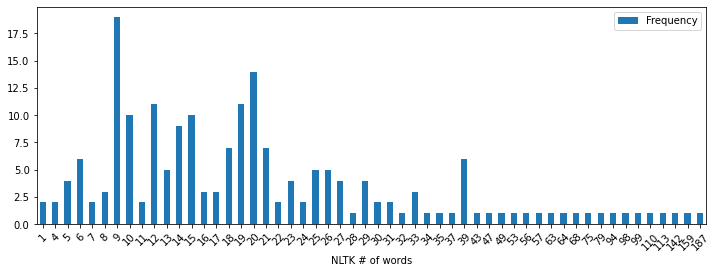

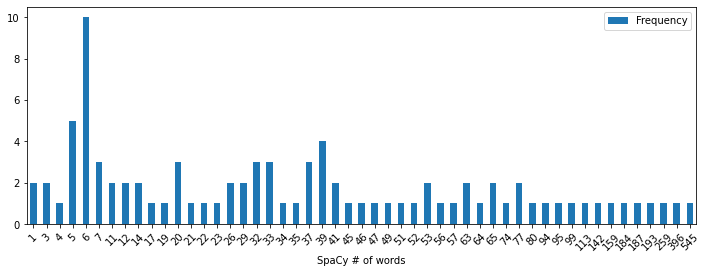

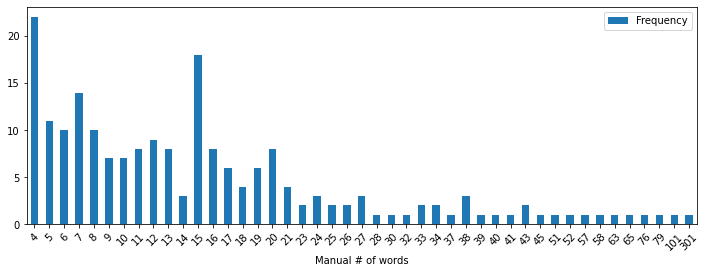

In [169]:
nltk_sents = get_nltk_sents(txt, es_tokenizer)
spacy_sents = get_spacy_sents(txt, es_nlp)
manual_sents = get_manual_sents(fname, lines)

print("Number of sentences identified by NLTK:", len(nltk_sents))
print("Number of sentences identified by spaCy:", len(spacy_sents))
print("Number of sentences identified by manual process:", len(manual_sents))
word_count_dist(nltk_sents, spacy_sents, manual_sents)

In [170]:
show_compare_sents(spacy_sents, nltk_sents, manual_sents)

Spacy sentence 0:  Biblioteca del Congreso Nacional
 --------------------------------





NLTK sentence 0:  Biblioteca del Congreso Nacional
 --------------------------------




Tipo Norma               :Decreto 60
Fecha Publicación        :22-03-2014
Fecha Promulgación       :07-06-2013
Organismo                :MINISTERIO DE BIENES NACIONALES
Título                   :DESAFECTA EL MONUMENTO NATURAL ALERCE COSTERO Y AMPLÍA EL
                          PARQUE NACIONAL ALERCE COSTERO, EN LAS COMUNAS DE CORRAL Y
                          LA UNIÓN, PROVINCIAS DE VALDIVIA Y DEL RANCO, REGIÓN DE
                          LOS RÍOS
Tipo Versión             :Única     De : 22-MAR-2014
Inicio Vigencia          :22-03-2014
Id Norma                 :1060445
URL                      :https://www.leychile.cl/N?i=1060445&f=2014-03-22




DESAFECTA EL MONUMENTO NATURAL ALERCE COSTERO Y AMPLÍA EL PARQUE NACIONAL ALERCE COSTERO, EN LAS COMUNAS DE CORRAL Y LA UNIÓN, PROVINCIAS DE VALDIVIA Y DEL RANCO,

In [151]:
# Now let's get some sample sentences with a given length
def sample_sents_by_word_count(sents, word_count_range, sents_idx, random=False):
    result_sents = []
    word_counts = [len(str(sent).split()) for sent in sents]
    
    for sent, count in zip(sents, word_counts):
        if word_count_range[0] <= count <= word_count_range[1]:
            result_sents.append(sent)
    
    if random:
        return random.sample(result_sents, sents_idx[1])
    return result_sents[sents_idx[0]:sents_idx[1]]

In [152]:
sample_sents_by_word_count(nltk_sents, [1, 10], [0, 30])

['e) Área de Uso Público.',
 'i) Comité de Ministros: Comité de Ministros del Turismo.',
 'j) Dirección Nacional: Dirección Nacional del Servicio Nacional de Turismo.',
 'k) Subsecretaría: Subsecretaría de Turismo.',
 'l) Subsecretario: Subsecretario de Turismo.']

In [145]:
sample_sents_by_word_count(spacy_sents, [1, 10], [0, 30])

[ Biblioteca del Congreso Nacional
  --------------------------------
 
 
 
 ,
 Tipo Norma               :Decreto 50
 Fecha Publicación        :28-04-2012,
 Tipo Versión             :Única     De : 28-ABR-2012,
 Inicio Vigencia          :28-04-2012,
 Id Norma                 :1039477,
 e) Área de Uso Público.,
 i) Comité de Ministros: Comité de Ministros del Turismo.
      ,
 j) Dirección Nacional: Dirección Nacional del Servicio Nacional de Turismo.
      ,
 k) Subsecretaría: Subsecretaría de Turismo.
      ,
 l) Subsecretario: Subsecretario de Turismo.
 
 
      ,
 Artículo 13.-,
 Artículo 19.-,
 Artículo 23.-]

In [154]:
sample_sents_by_word_count(manual_sents, [20, 40], [0, 30])

['Organismo :MINISTERIO DE ECONOMIA, FOMENTO Y TURISMO; SUBSECRETARIA DE ECONOMIA Y EMPRESAS DE MENOR TAMAÑO Titulo :APRUEBA REGLAMENTO QUE FIJA PROCEDIMIENTO PARA OTORGAMIENTO DE CONCESIONES TURISTICAS EN AREAS SILVESTRES PROTEGIDAS DEL ESTADO Tipo Version :Unica De : 28-ABR-2012',
 'Apruebase el siguiente reglamento que fija el procedimiento para otorgar concesiones turisticas en Areas Silvestres Protegidas del Estado, que sean priorizadas de acuerdo al Titulo V de la ley 20.423:',
 'Area Silvestre Protegida Priorizada: Son las Areas Silvestres Protegidas del Estado que disponen de Plan de Manejo y que han sido priorizadas para el desarrollo turistico por el Comite de Ministros del Turismo',
 'Parte del Area Silvestre Protegida del Estado que segun su Plan de Manejo, permite el uso, entre otros, para fines turisticos sustentables',
 'Las Areas Silvestres Protegidas del Estado no podran ser intervenidas ni concesionadas al sector privado sin contar con los respectivos planes de manejo

## Export sentences

In [189]:
import json

def export_sentences(sents, fname):
    output = {}
    
    for i, sent in enumerate(sents):
        output[f"Sentence_{i}"] = sent
        
    fname_json = fname.replace(".txt", ".json")
    with open(fname_json, "w", encoding="latin-1") as fout:
        json.dump(output, fout, indent=4)

In [190]:
export_sentences(nltk_sents, f"nltk_{fname}")

## Process all 

In [202]:
for fname in chile_paths:
    txt_path = base_path + fname

    with open(txt_path, "r") as txt_file:
        txt = txt_file.read()
        
    nltk_sents = get_nltk_sents(txt, es_tokenizer)
    export_sentences(nltk_sents, f"../output/nltk_{fname}")
    
    spacy_sents = get_spacy_sents(txt, es_nlp)
    export_sentences(spacy_sents, f"../output/spacy_{fname}")
    
    with open(txt_path, "r") as txt_file:
        lines = txt_file.readlines()
    
    manual_sents = get_manual_sents(fname, lines)
    export_sentences(manual_sents, f"../output/manual_{fname}")
    

## Observations

- It appears that spaCy gets confused with numbers (i.e 1.4 or 3.4) and counts them as their own sentence
- Replacing new lines, tabs and trailing spaces seem to benefit the sentence splitting for spaCy.
- spaCy seems to have troubles with symbols as well, such as lines --------

**TODO**:
- [x] Try looking at examples from different parts of the distribution
- [x] Check other documents - also Spanish from Chile and El Salvador
- [x] Compare with rule based system
- [x] Check how it handles semi-colons in Chile

**General TODO**:
- Make sure to define the PDF reading part well